# EDA on new patient dataframe

# Install libraries

In [1]:
#install requirements
!pip install seaborn
!pip install folium

# Import libraries

In [1]:
import pandas as pd
from collections import Counter 
from sqlalchemy import create_engine

import folium
from folium.features import DivIcon

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# Import sql databases as Dataframes

## Verify list of tables

In [2]:
#create engine to make connection to data base
db_schema = 'sqlite:///data.db'
engine = create_engine(db_schema, echo=False)
engine.table_names()

['new_patient', 'patient', 'patient_cleaned', 'test']

## Import sql databases as dataframes

In [21]:
#retrieve patient and test dataframes
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_new_patient = pd.read_sql('select * from new_patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

# Data Visualization

## pcr dataframe analysis

In [22]:
#display pcr dataframe
display(df_pcr)

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative
...,...,...
8795,249457,N
8796,279689,Positive
8797,975612,N
8798,884429,Positive


In [23]:
#get pcr dataframe info
df_pcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8800 non-null   int64 
 1   pcr         8800 non-null   object
dtypes: int64(1), object(1)
memory usage: 137.6+ KB


Tous ces deux colonnes n'ont pas de valeurs nulles*

In [24]:
#get pcr dataframe nunique values
df_pcr.nunique()

patient_id    8765
pcr              4
dtype: int64

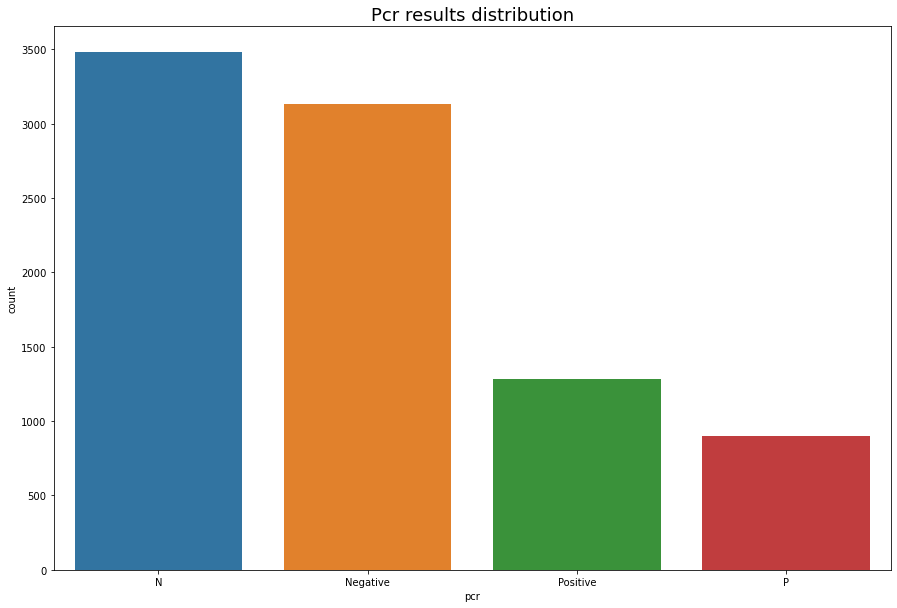

In [25]:
#visualize pcr results
plt.figure(figsize=(15,10))
sns.countplot(x='pcr',data=df_pcr).set_title("Pcr results distribution",fontsize=18)
plt.show()

On remarque que le nombre total de patient id égale a 8800 alors qu'on a seulement 8765. Du coup, il y des duplicates aussi pour cette dataframe et ca va nous poser des problème lors de la jointure avec new_patient dataframe. Aussi, le nombre unique du pcr égale à 4 alors logiquement on a seuelemt deux valeurs soit positive soit négative. Du coup, il faut qu'on vérifie cette colonne

In [26]:
#get pcr attribut unique values
df_pcr["pcr"].unique()

array(['N', 'Negative', 'Positive', 'P'], dtype=object)

In [27]:
#Replace Negative to N and Postive to P to get two unique values
df_pcr["pcr"] = df_pcr["pcr"].apply(lambda x: 'P' if x=='Positive' else  ('N' if x=='Negative' else x))
df_pcr["pcr"].unique()

array(['N', 'P'], dtype=object)

A ce stage la, on a résolu le problème du pcr colonne. Dans les prochaines étapes, on va se focaliser sur le problème des duplicates ids dans le datafame pcr. Pour cela, il faut qu'on vérifie si un id est dupliqué et les dupliqués ont des resultas de tests differents il faut les supprimer, Sinon on accorde le meme resultat aux nouveaux ids généré en utilisant le dictionnaire généré par la fonction get_id_duplicates utilisé dans le premier notebook.

In [28]:
def get_id_duplicates(df):
    
    """get id duplicates values  
    
    Parameters
    ----------
    df : dataframe
        patient informations dataframe
        
    Returns
    -------
    tuple
        contains new dataframe with assigned new ids to duplicates and dictionary contains duplicates id as keys and new assigned ids for the duplicates
    """
    
    new_df = df.copy()
    dict_ = {}
    i = 0
    
    #verify whether the duplicates on patient id have the same pcr result or not 
    for id,count in Counter(new_df.patient_id).most_common():
        
        #if ids is duplicated
        if count > 1:
            list_new_index = []
            #iterate over rows having the same id
            
            for idx,row in new_df[new_df["patient_id"]==id][1:].iterrows():
                i = i+1
                #assign new ids
                new_df.loc[idx,"patient_id"] = min(new_df["patient_id"])-i
                #get assigned ids into a list
                list_new_index += [min(new_df["patient_id"])-i]
                
            #create a dictionay contains duplicates id as keys and new assigned ids for the duplicates
            dict_[str(id)] = list_new_index
            
    return new_df, dict_

In [29]:
#get df_patient without id_duplicates and dictionary of duplicates and new assigned ids
_, dict_duplicates_id = get_id_duplicates(df_patient)

In [32]:
def clean_pcr_ids(df,dict_duplicates_id):
    
    """clean pcr ids before joins  
    
    Parameters
    ----------
    df : dataframe
        pcr informations dataframe
    dict_duplicates_id : dict
        contains duplicates id as keys and new assigned ids for the duplicates in first notebook
    Returns
    -------
    dataframe
        cleaned dataframe without duplicates
    """
        
    new_df = df.copy()
    #verify whether the duplicates on patient id have the same pcr result or not
    
    for id,count in Counter(new_df.patient_id).most_common():
        
        #detect duplicates ids
        if count > 1:
            
            #detect whether the id and its duplicates having same pcr result if set(results)=1 then yes otherwise not
            if len(set(new_df[new_df["patient_id"]==id]["pcr"])) != 1:
                #delete the id and its duplicates
                new_df = new_df[new_df.patient_id != id]
                
            elif len(set(new_df[new_df["patient_id"]==id]["pcr"])) == 1:
                #verify if id in dictionary keys
                
                if str(id) in dict_duplicates_id.keys():
                    
                    #verify if number of id duplicates in pcr dataframe equal to same id duplicates in patient dataframe
                    if count == len(dict_duplicates_id[str(id)])+1:
                        
                        #add new assigned ids in part one to new df
                        for el in dict_duplicates_id[str(id)]:
                            new_df = new_df.append({'patient_id':int(el), 'pcr':new_df[new_df["patient_id"]==id].iloc[0]["pcr"]}, ignore_index=True)
                            
        #keep only first id and delete its duplicates as they were replcaed by new ids
    new_df.drop_duplicates(keep = 'first',inplace=True)
    new_df = new_df.reset_index(drop=True)
    
    return new_df

In [33]:
#get cleaned pcr dataframe
df_pcr = clean_pcr_ids(df_pcr,dict_duplicates_id)

In [34]:
#display cleaned pcr dataframe
display(df_pcr)

,patient_id,pcr
0,653091,N
1,347667,N
2,708481,P
3,148825,N
4,150081,N
...,...,...
8767,85810,N
8768,99303,N
8769,99510,N
8770,98466,N


In [35]:
df_pcr.nunique()

patient_id    8772
pcr              2
dtype: int64

Maintenant on a finit le cleaning des données et tout va bien avec le dataframe pcr

## Join of new pation dataframe without duplicates with df_pcr dataframe

In [36]:
#joins df_pce and df_new_patient id with state and age columns
new_merged_data = pd.merge(df_pcr,df_new_patient[["state","age","patient_id"]],on='patient_id')

In [37]:
#display merged data frame
display(new_merged_data)

,patient_id,pcr,state,age
0,653091,N,nsw,NaN
1,347667,N,wa,28.0
2,708481,P,sa,NaN
3,148825,N,qld,19.0
4,150081,N,qld,35.0
...,...,...,...,...
8137,103358,N,sa,12.0
8138,279689,P,tas,NaN
8139,975612,N,nsw,NaN
8140,884429,P,wa,NaN


In [38]:
#get nunique values
new_merged_data.nunique()

patient_id    8142
pcr              2
state            8
age             45
dtype: int64

In [39]:
df_new_patient.state.unique()

array(['wa', 'nsw', 'qld', 'nt', None, 'act', 'vic', 'sa', 'tas'],
      dtype=object)

On remarque que tous les states sont valides sauf un state a un None value qu'il sera abandonné dans la suite de nos analyses.

In [40]:
#create new df_tests dataframe contains count of total pcr tests, total positive tests and total negative tests per state
df_tests = pd.DataFrame()
df_tests["pcr_P"] = new_merged_data[new_merged_data.pcr == "P"].groupby('state')['pcr'].count()
df_tests["pcr_N"] = new_merged_data[new_merged_data.pcr == "N"].groupby('state')['pcr'].count()
df_tests["pcr_T"] = new_merged_data.groupby('state')['pcr'].count()

In [41]:
display(df_tests)

,pcr_P,pcr_N,pcr_T
state,,,
act,29,82,111
nsw,600,1834,2434
nt,4,43,47
qld,357,1080,1437
sa,126,451,577
tas,54,157,211
vic,480,1331,1811
wa,177,512,689


In [42]:
#construct df_geo_coordinates dataframe to get latitude and ligitude of each state to be used to represent data per state on australia map
df_geo_coordinates = pd.DataFrame.from_dict({'lat':[-37.4713,-31.2532,-20.9176,-30.0002,-41.4545,-27.6728,-35.4735,-19.4914],'lon':[144.7852,146.9211,142.7028,136.2092,145.9707,121.6283,149.0124,132.5510],'state':["vic","nsw","qld","sa","tas","wa","act","nt"]})

In [43]:
#construnt a new dataframe to be used for visualization
df_state_geo_tests_pcr = pd.merge(df_tests,df_geo_coordinates,on='state')

In [44]:
display(df_state_geo_tests_pcr)

,state,pcr_P,pcr_N,pcr_T,lat,lon
0,act,29,82,111,-35.4735,149.0124
1,nsw,600,1834,2434,-31.2532,146.9211
2,nt,4,43,47,-19.4914,132.5510
3,qld,357,1080,1437,-20.9176,142.7028
4,sa,126,451,577,-30.0002,136.2092
5,tas,54,157,211,-41.4545,145.9707
6,vic,480,1331,1811,-37.4713,144.7852
7,wa,177,512,689,-27.6728,121.6283


## Visualize total tests per state (bar & pie charts)

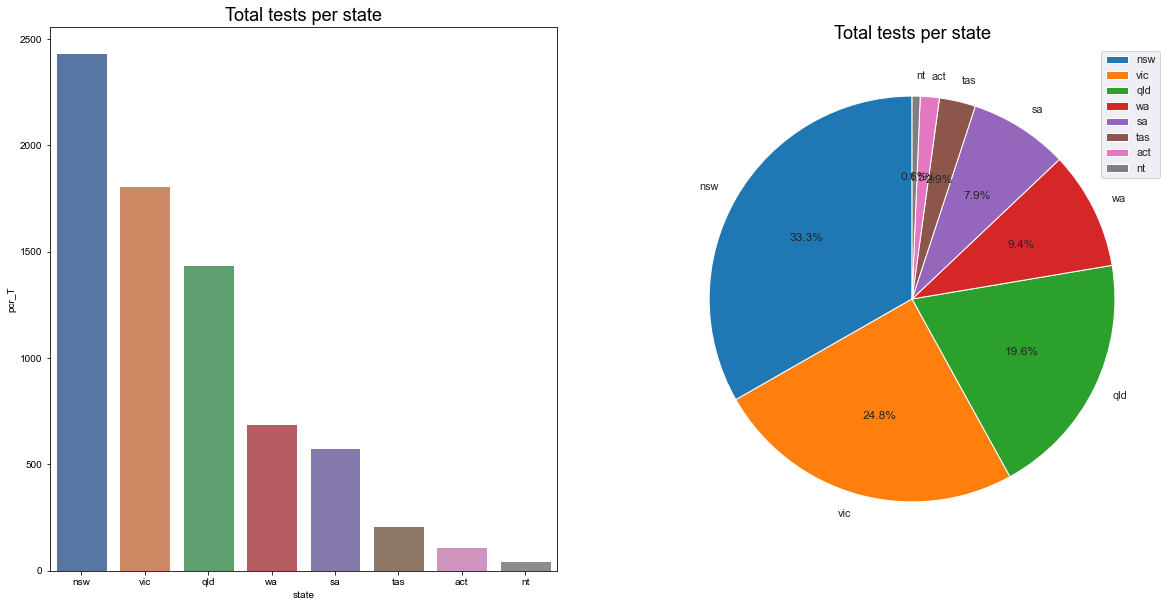

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(x="state",y="pcr_T", data=df_state_geo_tests_pcr.sort_values(['pcr_T'],ascending=False).reset_index(drop=True),ax=ax1)

# defining labels 
activities = df_state_geo_tests_pcr.sort_values(['pcr_T'],ascending=False)['state']  
# portion covered by each label 
slices = df_state_geo_tests_pcr.sort_values(['pcr_T'],ascending=False)['pcr_T']
  
# plotting the pie chart 
ax2.pie(slices, labels = activities,  
        startangle=90, 
        radius = 1, autopct = '%1.1f%%') 

# plotting legend 
ax2.legend(loc="upper right")

# plotting titles 
ax1.set_title("Total tests per state", fontsize=18)
ax2.set_title("Total tests per state", fontsize=18)

plt.show()

On peut remarquer que le nombre de tests realisé est plus élevé en nsw state puis vic, qld, wa, sa, tas, act et finalement nt ayant le minimum nombre de tests comme elle a moins de population présente dans cet state. Aussi, le nombre des tests est bien proportionnel aux populations selon le lien suivant https://en.wikipedia.org/wiki/Postcodes_in_Australia

## Visualize total positive and negative tests per state (bar chart)

In [46]:
#construct new percent dataframe having the percentage of positive and negative tests per state
x,y = 'state', 'pcr'
df_state_percent = new_merged_data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

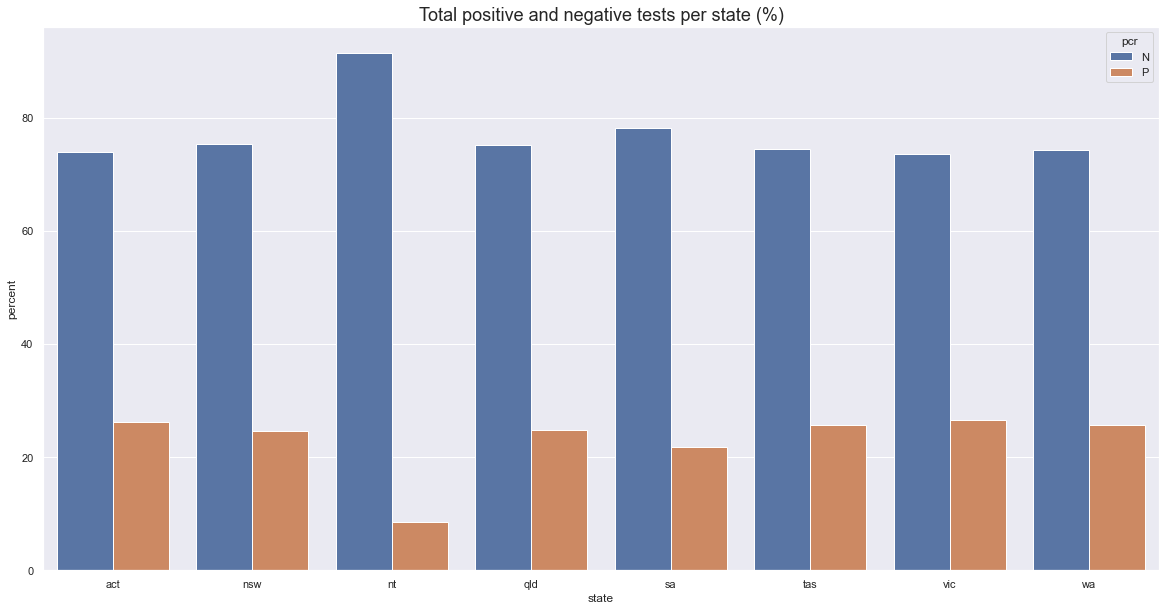

In [47]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(x='state',y='percent',hue='pcr',data=df_state_percent).set_title("Total positive and negative tests per state (%)",fontsize=18)
plt.show()

On remarque que pour la plupart des states le poucentage des positives tests (entre 75% et 80%) et negative tests (entre 20% et 30%) est le meme. Alors que le nt state a un pourcentage de tests negatifs entre 90% et 100% et de test positifs moins de 10%. cela pourra etre expliqué du fait que nt represente le troisième state en Australie ayant de frand surface et aussi elle a un peu nombre de population en comparant des autres states.

## Visualize total positive and negative tests per age (bar chart)

Australia age distribution:

* 0-14 years: 17,75% (Men 2.138.080 /Women 2.027.583)
* 15-24 years: 12,62% (Men 1.520.528 /Women 1.442.461)
* 25-54 years: 41,35% (Men 4.944.587 /Women 4.760.752)
* 55-64 years: 11,84% (Men 1.379.681 /Women 1.398.177)
* 65 + : 16,44% (Men 1.786.595 /Women 2.071.701) (2018 est.)

Ref : https://www.indexmundi.com/fr/australie/repartition_par_age.html

In [48]:
def subdivise_age_column(x):
    
    """label age data 
    
    Parameters
    ----------
    x : list
        list of patient informations
    
    Returns
    -------
    list
        a list with new age_label column 
    """
    
    #verify if age in [0,14]
    if pd.notnull(x["age"]):
        
        if x["age"] < 15:
            x["age_label"] = "0 to 14"

        #verify if age in [15,24]
        elif x["age"] < 25:
            x["age_label"] = "15 to 24"

        #verify if age in [25,54]
        elif x["age"] < 55:
            x["age_label"] = "25 to 54"

        #verify if age in [55,64]
        elif x["age"] < 65:
            x["age_label"] = "55 to 64"

        #verify if age > 64
        else:
            x["age_label"] = "65+"
            
        return (x)
    
    else:
        
        return x

In [49]:
#add age_label column
df_age = new_merged_data.apply(subdivise_age_column,axis=1)

In [50]:
display(df_age)

,age,age_label,patient_id,pcr,state
0,NaN,NaN,653091,N,nsw
1,28.0,25 to 54,347667,N,wa
2,NaN,NaN,708481,P,sa
3,19.0,15 to 24,148825,N,qld
4,35.0,25 to 54,150081,N,qld
...,...,...,...,...,...
8137,12.0,0 to 14,103358,N,sa
8138,NaN,NaN,279689,P,tas
8139,NaN,NaN,975612,N,nsw
8140,NaN,NaN,884429,P,wa


In [51]:
#get age_label unique values
df_age.age_label.unique()

array([nan, '25 to 54', '15 to 24', '0 to 14', '65+'], dtype=object)

On remarque que 4 catégories figurent dans la colonne age_label et un autre nan qui sera abondonné dans la suite de nos analyses

In [52]:
#construct new percent dataframe having the percentage of tests conducted on a particular subdivision age per state
x,y = 'state', 'age_label'
df_age_percent = df_age.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

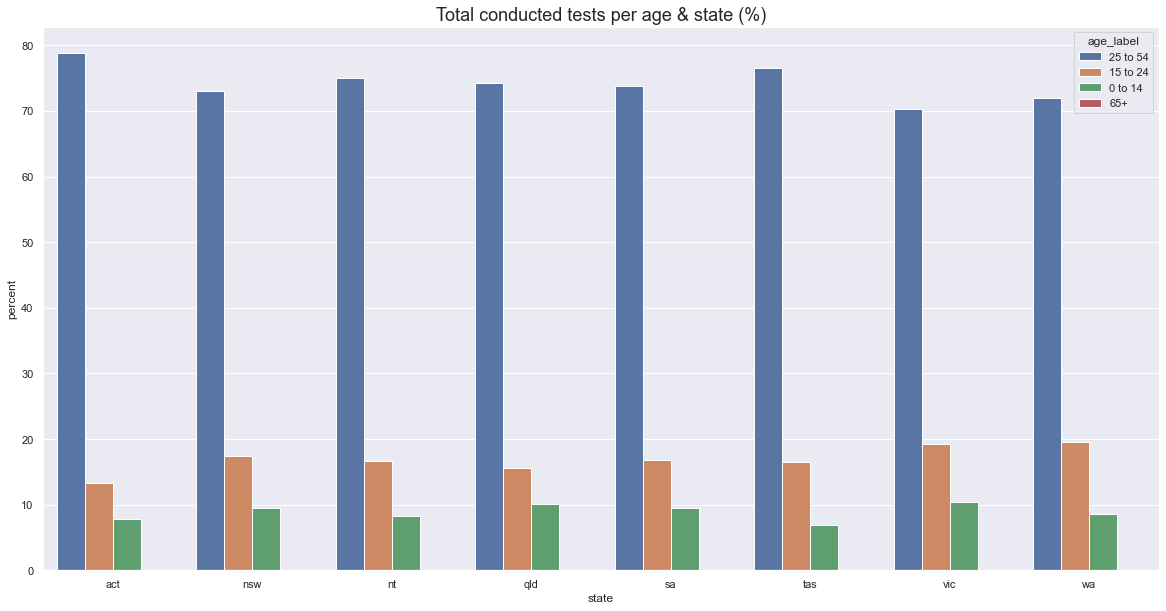

In [53]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(x='state',y='percent',hue='age_label',data=df_age_percent).set_title("Total conducted tests per age & state (%)",fontsize=18)
plt.show()

D'près cette figure, on remarque que le nombre de tests effectué est proportionnel pa rapprot a la population de l'australie. En fait, D'après la source illustrée en haut, la tranche d'age entre 25 et 54 représente environ 41% ce qui est logique que le nombre de test sur cette tranche d'age est plus elevé que pour les autres.

### Visualize positive and negative tests per state and per age

Text(0.5, 0.98, 'Total conducted positive and negative tests per age')

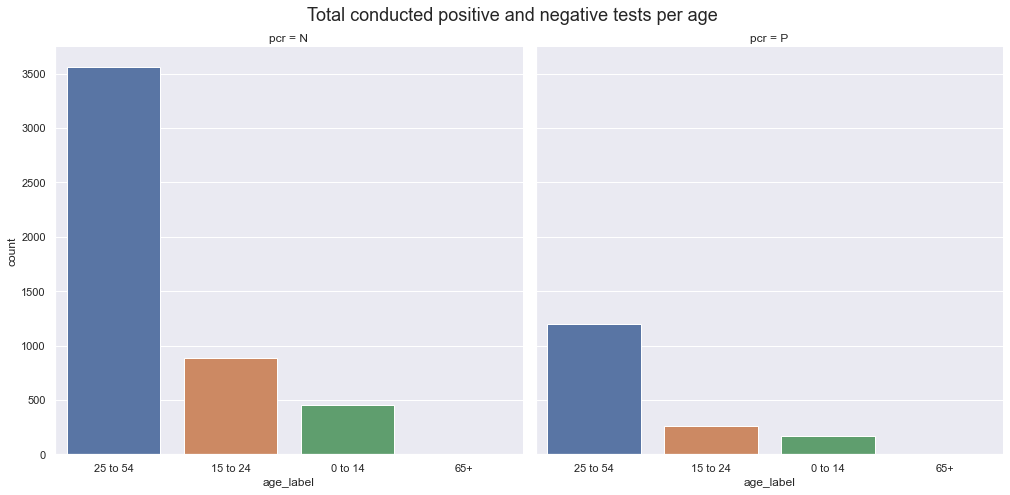

In [54]:
sns.set(style="darkgrid")
g = sns.catplot(x="age_label", col="pcr",data=df_age, kind="count",height=7)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Total conducted positive and negative tests per age",fontsize=18)

D'après ces deux figures on peut conclure que le nombre de tests positifs est plus élevé pour la tranche d'age entre 25 et 54 ans qui représente environ 41%. Du coup, on remarque que le coronavirus est se repandent plus vites pour la tanche d'âge actif (15-24 ans) , âge d'entrée en activité (25-54 ans) et l'âge adulte (55-64 ans) plus que les autres tranches d'ages dans l'australie. Aussi la question qui se pose, logiquement on devrait avoir des résultats importants pour la tranche d'age +65 alors que il y rien du coup il faut investiguer la tranche d'age +65

In [60]:
#get data when age_label == 65+
df_age[df_age.age_label == "65+"]

,age,age_label,patient_id,pcr,state
7232,83.0,65+,410258,N,vic


Un seul element a un age plus que 65 ans du coup c'est tout a fait logique de ne pas voir cette tranche d'age dans les figures ci dessus

### Map visualization

In [55]:
#scale number of positive pcr tests to be represented in the Australia map
min_pcr_positive_tests = min(df_state_geo_tests_pcr['pcr_P'])
max_pcr_positive_tests = max(df_state_geo_tests_pcr['pcr_P'])
                             
df_state_geo_tests_pcr['scaled_pcr_P'] = df_state_geo_tests_pcr['pcr_P'].apply(lambda x: 10 + 20*(x-min_pcr_positive_tests)/(max_pcr_positive_tests-min_pcr_positive_tests))

In [56]:
#display df_state_geo_tests_pcr dataframe
display(df_state_geo_tests_pcr)

,state,pcr_P,pcr_N,pcr_T,lat,lon,scaled_pcr_P
0,act,29,82,111,-35.4735,149.0124,10.838926
1,nsw,600,1834,2434,-31.2532,146.9211,30.000000
2,nt,4,43,47,-19.4914,132.5510,10.000000
3,qld,357,1080,1437,-20.9176,142.7028,21.845638
4,sa,126,451,577,-30.0002,136.2092,14.093960
5,tas,54,157,211,-41.4545,145.9707,11.677852
6,vic,480,1331,1811,-37.4713,144.7852,25.973154
7,wa,177,512,689,-27.6728,121.6283,15.805369


## Map of positive test cases

### Create Australia map to represent positive test cases: 
* Display a state when hovering over the object (circle).
* Display the number of positive cases when clicking on object (circle).

In [57]:
#get Australia map
australia_map = folium.Map((-25.2744, 133.7751),zoom_start=5)
#draw circles which represent state on map whith test positive informations
for idx,row  in df_state_geo_tests_pcr.iterrows():
    folium.CircleMarker(
            [row['lat'], row['lon']],
            radius=row['scaled_pcr_P'],
            popup="{} tested positive cases".format(row['pcr_P']),
            fill=True,
            tooltip=row['state'],
            color='red',
            fill_color='red',
            fill_opacity=0.6,
            ).add_to(australia_map)
    
    #add number of positive cases to circle
    folium.Marker(
    [row['lat'], row['lon']],
    icon=DivIcon(
        icon_size=(row['scaled_pcr_P'],row['scaled_pcr_P']),
        icon_anchor=(7,7),
        html='<div style="font-size: 9pt">%s</div>' % row['pcr_P'],
        )
    ).add_to(australia_map)
    
australia_map